# Tree Based Model Practice
## Key Points
### 1 - Decision Tree simple model example with Tree View, recursive partition algrithm visulization
### 2 - Measure of Impurity
### 3 - Bagging and Random Forest
### 4 - Xgboost
### 5 - Grid Search

Import required Python packages.

In [1]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import pydotplus
from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

no display found. Using non-interactive Agg backend


Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [2]:
DATA = Path('.').resolve().parents[1] / 'IntermediateLevel/DataScienceProgram/Class3/tree'

In [3]:
LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'

Set this if the notebook crashes in the XGBoost part.

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Tree Models
## A simple tree with visulization
The package _scikit-learn_ has the class `DecisionTreeClassifier` to build a decision tree model. The function `plotDecisionTree` from the _dmba_ package can be used to visualize the tree. 

##### Fit the tree model

In [5]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.003, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

##### Use exisitng module from dmba package for visulization

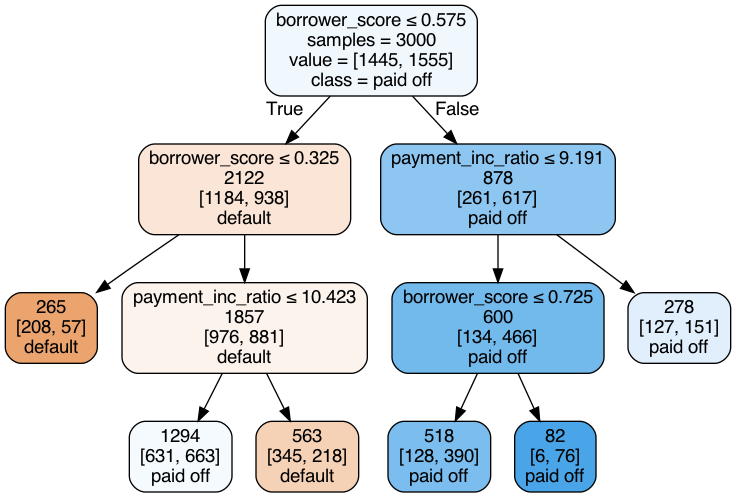

In [6]:
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

##### Use SKlearn module and imamge to visulize 

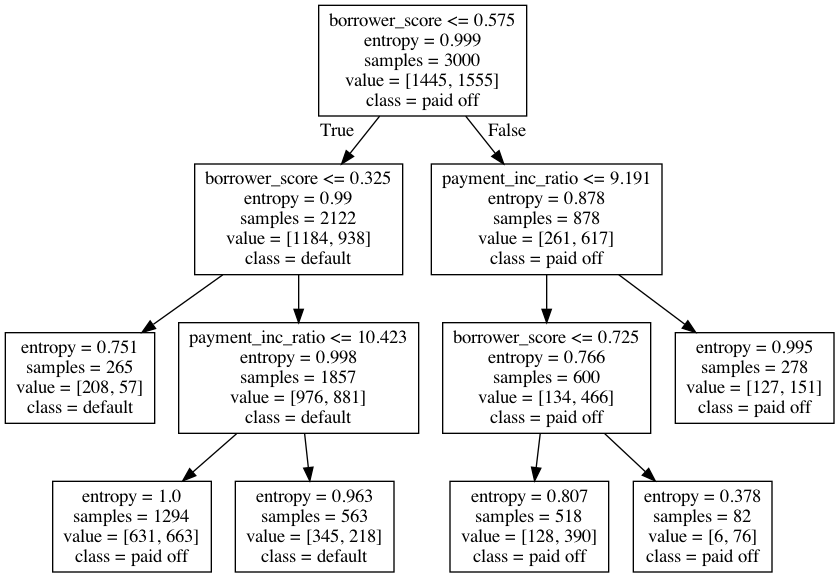

In [7]:
from sklearn import tree
from IPython.display import Image 
# Create DOT data
dot_data = tree.export_graphviz(loan_tree, out_file=None, 
                                feature_names=predictors,  
                                class_names=loan_tree.classes_)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

##### Print tree in text format

In [8]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


More ways to visulize decision tree [here](https://mljar.com/blog/visualize-decision-tree/).

And a good extra [reading material](https://sebastianraschka.com/faq/docs/decisiontree-error-vs-entropy.html)

## The Recursive Partitioning Algorithm and Tree example display the Algorithm
The data is repeatedly partitioned using predictor values which could do the best job of separating the data into relatively homogeneous partitions respect to target

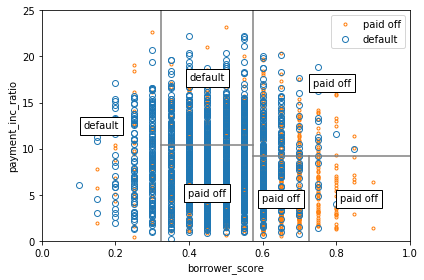

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725
ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

## Measuring Homogeneity or Impurity

In [10]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

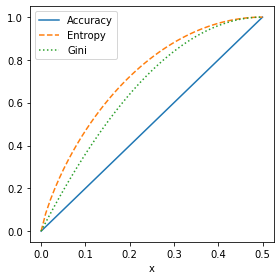

In [11]:
x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

Gini or Entorpy, which one to use? 

A [simulation](https://quantdare.com/decision-trees-gini-vs-entropy/) work disclose the answer.

# Bagging and the Random Forest
## Random Forest

#### Fit a simple random forest model

In [12]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, 
                            oob_score=True)
rf.fit(X, y)
print(rf.oob_decision_function_)
print(rf.oob_score_)

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]
0.5753333333333334


A nice thing of RF is the OOB_score, explained [here](https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710). That is another way to evaluate model performance but not to use the model training data. And this is a quick way, especially useful if your data is precious.

In [13]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rfc = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rfc.fit(X, y)
    oobScores.append(rfc.oob_score_)

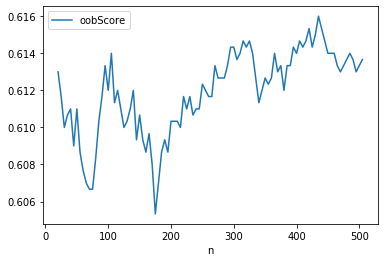

In [14]:
pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')

## Exercise 1
#### 1 - Please recreate the above chart using testing dataset which created through train-test spliting
#### 2 - Please compare the result between OOB score and test score

In [15]:
from sklearn.metrics import roc_auc_score
loan3000_2=loan3000.copy()
loan3000_2['dv'] = [1 if out=="default" else 0 for out in loan3000['outcome']]


predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'dv'

# prepare train-test split
X = loan3000_2[predictors]
y = loan3000_2[outcome]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n_estimator = list(range(20, 510, 5))
testScores = []

for n in n_estimator:
    rfc = RandomForestClassifier(n_estimators=n, random_state=1)
    rfc.fit(X_train, y_train)

    # predictions
    auc=roc_auc_score(y_test, rfc.predict(X_test), average='macro')
    testScores.append(auc)
    #print(n,auc, sum(y_test), sum(rfc.predict(X_test)))

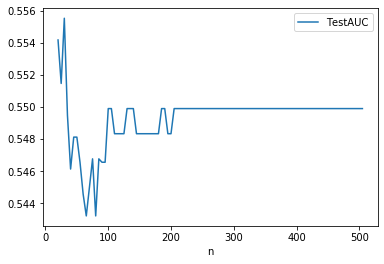

In [16]:
pd.DataFrame({
    'n': n_estimator, 
    'TestAUC': testScores
}).plot(x='n', y='TestAUC')

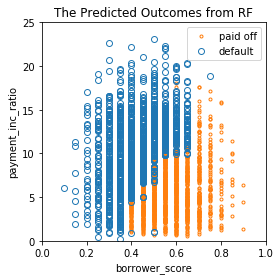

In [17]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.title("The Predicted Outcomes from RF")
plt.tight_layout()
plt.show()

#### Random forest overfitting can be observed

## Variable importance


In [18]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

In [19]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=100, random_state=1)
rf_all.fit(X, y)
print(rf_all.fit(X, y))

rf_all_entropy = RandomForestClassifier(n_estimators=100, random_state=1,
                                        criterion='entropy')
print(rf_all_entropy.fit(X, y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=

In [20]:
rf = RandomForestClassifier(n_estimators=200)
scores = defaultdict(list)
 
# crossvalidate the scores on a number of different random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                          test_size=0.3)
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

Features sorted by their score:
[(0.0724, 'borrower_score'), (0.0381, 'grade'), (0.0259, 'term_60 months'), (0.0131, 'annual_inc'), (0.0075, 'payment_inc_ratio'), (0.0038, 'purpose_small_business'), (0.0022, 'dti'), (0.002, 'revol_bal'), (0.0019, 'delinq_2yrs_zero'), (0.0015, 'purpose__small_business'), (0.0014, 'home__RENT'), (0.0012, 'revol_util'), (0.001, 'purpose_other'), (0.0009, 'home__OWN'), (0.0005, 'emp_len__ > 1 Year'), (0.0004, 'purpose_medical'), (0.0004, 'pub_rec_zero'), (0.0003, 'purpose_wedding'), (0.0003, 'purpose__medical'), (0.0002, 'purpose_major_purchase'), (0.0002, 'purpose_home_improvement'), (0.0001, 'purpose_vacation'), (0.0001, 'purpose_moving'), (0.0001, 'purpose_house'), (0.0001, 'purpose_credit_card'), (0.0001, 'purpose__major_purchase'), (0.0001, 'purpose__home_improvement'), (-0.0001, 'open_acc'), (-0.0004, 'purpose__other'), (-0.0005, 'emp_length'), (-0.0014, 'purpose_debt_consolidation'), (-0.0016, 'loan_amnt'), (-0.0027, 'purpose__debt_consolidation')]


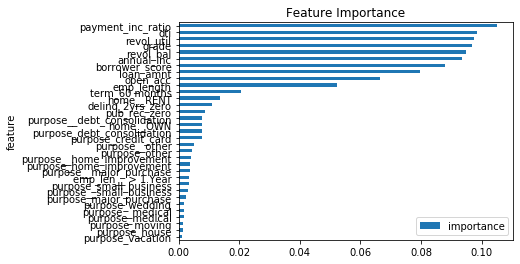

In [29]:
df = pd.DataFrame({
    'feature': X.columns, 
    'importance': rf_all.feature_importances_
})
df = df.sort_values('importance')

ax = df.plot(kind='barh', x='feature', y='importance', 
             title="Feature Importance")

plt.show()

# Boosting
## XGBoost

In [33]:
loan3000.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


In [20]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

xgb = XGBClassifier(objective='binary:logistic', subsample=.63)
print(xgb.fit(X, y))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.63, verbosity=1)


In [21]:
xgb_df = X.copy()
xgb_df['prediction'] = xgb.predict(X)
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.439195
1            0.40            5.43165    default      0.557564
2            0.70            9.23003   paid off      0.315249
3            0.40            2.33482   paid off      0.461870
4            0.45           12.10320    default      0.630166


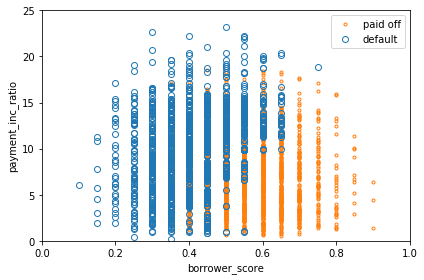

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

## Regularization: Avoiding Overfitting

In [23]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=0, learning_rate=0.3, subsample=1)
xgb_default.fit(train_X, train_y)

xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63, colsample_bytree=0.7)
print(xgb_penalty.fit(train_X, train_y))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1000, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.63, verbosity=1)


In [24]:
pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

default (train):  0.12882689151717502
default:  0.3562
penalty:  0.3262


In [25]:
results = []
for ntree_limit in range(1, 250):
    train_default = xgb_default.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    results.append({
        'iterations': ntree_limit,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

results = pd.DataFrame(results)
print(results.head())

   iterations  default train  penalty train  default test  penalty test
0           1       0.339256       0.333682        0.3483        0.3484
1           2       0.329721       0.334758        0.3391        0.3429
2           3       0.326722       0.338521        0.3361        0.3456
3           4       0.324288       0.340049        0.3359        0.3452
4           5       0.320950       0.340756        0.3345        0.3460


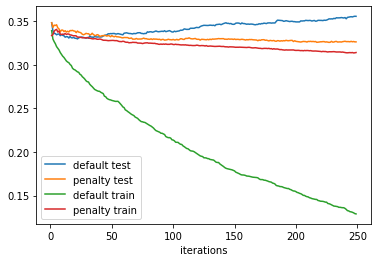

In [26]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)
plt.show()

## Hyperparameters and Cross-Validation

### Small scale grid search

In [27]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250, 
                        max_depth=max_depth, learning_rate=eta)
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.3282672843342188}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.33467396531571836}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.3443048132867525}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.3399452119041025}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.368644454287477}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.37086190792431467}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.3525883957906859}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.38882541701308243}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.3830866137729649}
   eta  max_depth  avg_error
0  0.1          3   0.328267
1  0.1          6   0.334674
2  0.1          9   0.344305
3  0.5          3   0.339945
4  0.5          6   0.368644
5  0.5          9   0.370862
6  0.9          3   0.352588
7  0.9          6   0.388825
8  0.9          9   0.383087


In [28]:
print(errors.pivot_table(index='eta', columns='max_depth', values='avg_error') * 100)

max_depth          3          6          9
eta                                       
0.1        32.826728  33.467397  34.430481
0.5        33.994521  36.864445  37.086191
0.9        35.258840  38.882542  38.308661


### Exercise 2: 
Could you extend the grid serch to three or more parameters? 

Could you extend parameter tuning to random search or Bayesian search? (hint: sklearn has `RandomizedSearchCV`, for Bayesian search there are multiple packages that can help, you can see one example here: https://towardsdatascience.com/hyperparameter-tuning-always-tune-your-models-7db7aeaf47e9)

In [ ]:
# grid search

from sklearn.model_selection import GridSearchCV

# set up model
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
)

# set up parameter
parameters = {
    'eta' : [0.1, 0.5, 0.9],
    'max_depth' : [3, 6, 9],
    'colsample_bytree' : [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 1]
}

# set up grid search cv
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5,
    verbose=True
)

# Fit grid search
grid_result = grid_search.fit(X, y)

# Print grid search summary
grid_result

In [ ]:
# random search
from sklearn.model_selection import RandomizedSearchCV


# Define the search space
param_grid = { 
    "eta": [0.0001,0.001, 0.01, 0.1, 1] ,
    "max_depth": range(3,21,3),
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    "gamma": [i/10.0 for i in range(0,5)],
}

# Define random search
random_search = RandomizedSearchCV(estimator=estimator, 
                                   param_distributions=param_grid, 
                                   n_iter=48,
                                   scoring='roc_auc',
                                   n_jobs=-1, 
                                   cv=5, 
                                   verbose=True)
# Fit random search
random_result = random_search.fit(X, y)

# Print random search summary
random_result